In [53]:
import spotipy
import spotipy.util as util
from spotipy.oauth2 import SpotifyOAuth

In [54]:
import pandas as pd
import plotly.io as pio
import plotly.express as px
import plotly.graph_objects as go
from wordcloud import WordCloud
import matplotlib.pyplot as plt
import requests

# " Authorization "

In [55]:
clientid = '1902a4edef574a73afa3a5df1d3a6373'
clientsecret = '1b633f65a71544388fd1e5aa971d0465'
redirecturi = "http://localhost:5000/callback/"

In [56]:
auth_manager=SpotifyOAuth(client_id= clientid,
                          client_secret=clientsecret,
                          redirect_uri=redirecturi,
                          scope='user-library-read user-follow-read user-top-read user-read-recently-played')
sp=spotipy.Spotify(auth_manager=auth_manager)

# To get the latest albums

In [57]:
results= sp.new_releases(country="IT", limit=10, offset=0)
photos=[]

for i in range(10):
    img_url=results["albums"]["items"][i]["images"][0]["url"]
    photos.append(img_url)
    
i=0
for url in photos:
    response= requests.get(url)
    file=open(f"images/fulls/sample_image{i}.png","wb")
    file.write(response.content)
    i+=1
file.close()

# "Manipulation of SP object"

### 1) Followed Artists of the user

In [58]:
artist_db=pd.DataFrame(columns=['id','name','genres','followers','popularity'])
result=sp.current_user_followed_artists(limit=20, after=None)
for j in range(100):
    for artist in result['artists']['items']:
        artist_db=artist_db.append({'id':artist['id'],
                                    'name':artist['name'],
                                    'genres':artist['genres'],
                                    'followers':artist['followers']['total'],
                                    'popularity':artist['popularity']},
                                   ignore_index=True)
        
        result =sp.current_user_followed_artists(after=artist['id'])
    if len(result['artists']['items'])==0:
        break
        
print(artist_db)

                         id                     name  \
0    00E0xvoM67oRJk8a5iTyEh              Ondatrópica   
1    00sazWvoTLOqg5MFwC68Um             Yann Tiersen   
2    02IFYoziC7CpQRK8fbehUY         Dubioza kolektiv   
3    03ApzEyHHRpivqgZ676gXK                  anna RF   
4    040hze5aLmq4IDXPDQfUDL          Nass El Ghiwane   
..                      ...                      ...   
221  7s4I6rDvTcdBDKElVbtsAN                  Bombino   
222  7x1riqKyOjly8udO9DhPVi            Hayseed Dixie   
223  7x83XhcMbOTl1UdYsPTuZM                Tom Waits   
224  7y97mc3bZRFXzT2szRM4L4          Frédéric Chopin   
225  7zOeqrVhezb7ogyGfeclqV  Boban Markovic Orkestar   

                                                genres followers popularity  
0    [chicha, cumbia, folclor afrocolombiano, latin...     40931         45  
1    [bow pop, compositional ambient, french soundt...    854757         69  
2                       [bosnian indie, yugoslav rock]     70882         47  
3              

### 2) Genres of artists (and subsequently of user)

In [59]:
# create a list with user favourite genres
genres_list=[]
for item in artist_db['genres']:
    for genre in item:
        genres_list.append(genre)

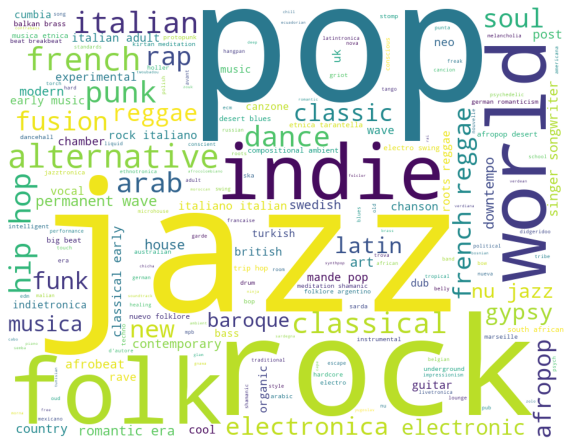

In [60]:
# create a wordbubble with user's favourite genres
words = genres_list

plt.subplots(figsize = (10,10))

wordcloud = WordCloud (background_color = 'white',
                       width = 900,
                       height = 700).generate(' '.join(words))


plt.imshow(wordcloud) # image show
plt.axis('off') # to off the axis of x and y
plt.savefig('images/results/taste1.png')
plt.show()

### 3) most popular artists of user

In [61]:
# create a scatterplot with user's most popular artist
df_top=artist_db.sort_values(by='popularity').tail(10)
df_top['size']=2

fig = px.scatter(df_top[['popularity','followers','name','size']], x="popularity", y="followers",color='name',size='size')
fig.update_layout(width=900, height=700)
fig.write_image("images/results/taste2.png")
fig.show()

### 4) user's top Tracks and Artists in time

In [62]:
#request of user's top tracks and artists
mr_tracks = sp.current_user_top_tracks(time_range='short_term') #Client Module
mr_tracks_now= sp.current_user_top_tracks(limit=10,time_range='short_term') 
mr_tracks_ever= sp.current_user_top_tracks(limit=10,time_range='long_term')
mr_artists_now= sp.current_user_top_artists(limit=10,time_range='short_term')
mr_artists_ever= sp.current_user_top_artists(limit=10,time_range='long_term')

### "def" to make dataframes

In [63]:
#function to export spotify top-objects into a database
def create_db(spot_obj):
    df=pd.DataFrame(columns=['number','name','id'])
    pos=1                
    for track in spot_obj['items']:
        df=df.append({'name':track['name'],'number':pos,'id':track['id']},ignore_index=True)
        pos+=1
    return df

### "def" to plot

In [64]:
#function to plot the top-ten tracks in panda.DataBase format
def topten(df):   
    colors = ['rgb(239, 243, 255)',
              'rgb(239, 243, 255)',
              'rgb(239, 243, 255)',
              'rgb(189, 215, 231)',
              'rgb(189, 215, 231)',
              'rgb(189, 215, 231)',
              'rgb(189, 215, 231)',
              'rgb(107, 174, 214)',
              'rgb(107, 174, 214)',
              'rgb(107, 174, 214)']
    
    df['Color']=colors
    fig = go.Figure(data=[go.Table(columnwidth = [50,200],
                                   header=dict(values=['<b>Number</b>', '<b>Track</b>'],
                                               fill_color='white',
                                               align='center',
                                               font=dict(color='black', size=17)),
                                   cells=dict(values=[df.number[0:10], df.name[0:10]],
                                              align='center',line_color=[df.Color],
                                              fill_color=[df.Color],
                                              font=dict(color='black', size=14),
                                              height=40))
                         ])
    
    fig.update_layout(width=900, height=700)
    return fig
    
#function to plot the top-ten artists
def topten_artists(df):   
    colors = ['rgb(239, 243, 255)',
              'rgb(239, 243, 255)',
              'rgb(239, 243, 255)',
              'rgb(189, 215, 231)',
              'rgb(189, 215, 231)',
              'rgb(189, 215, 231)',
              'rgb(189, 215, 231)',
              'rgb(107, 174, 214)',
              'rgb(107, 174, 214)',
              'rgb(107, 174, 214)']
    
    df['Color']=colors
    fig = go.Figure(data=[go.Table(columnwidth = [50,200],
                                   header=dict(values=['<b>Number</b>', '<b>Artist</b>'],
                                               fill_color='white',
                                               align='center',
                                               font=dict(color='black', size=17)),
                                   cells=dict(values=[df.number[0:10], df.name[0:10]],
                                              align='center',line_color=[df.Color],
                                              fill_color=[df.Color],
                                              font=dict(color='black', size=14),
                                              height=40))
                         ])
    
    fig.update_layout(width=900, height=700)
    return fig

### make the dataframes

In [65]:
top_tracks_now_df=create_db(mr_tracks_now)
top_tracks_ever_df=create_db(mr_tracks_ever)
top_artists_now_df=create_db(mr_artists_now)
top_artists_ever_df=create_db(mr_artists_ever)

### Now plot them

In [66]:
fig=topten(top_tracks_now_df)
fig.write_image("images/results/top1.png")
fig.show()

In [67]:
fig=topten(top_tracks_ever_df)
fig.write_image("images/results/top2.png")
fig.show()

In [68]:
fig=topten_artists(top_artists_now_df)
fig.write_image("images/results/top3.png")
fig.show()

In [69]:
fig=topten_artists(top_artists_ever_df)
fig.write_image("images/results/top4.png")
fig.show()

### still top tracks

In [70]:
#convert 20 most listened song in a dataframe
top_tracks_df=pd.DataFrame(columns=['number','name'])
for pos,track in enumerate(mr_tracks['items']):
    top_tracks_df=top_tracks_df.append({'name':track['name'],
                                        'number':pos+1,
                                        'liveness':sp.audio_features(track['id'])[0]['liveness'],
                                        'energy':sp.audio_features(track['id'])[0]['energy'],
                                        'loudness':sp.audio_features(track['id'])[0]['loudness'],
                                        'danceability':int((sp.audio_features(track['id'])[0]['danceability'])*100)},
                                       ignore_index=True)

In [71]:
#plot top listened track features
df = px.data.gapminder()

fig = px.scatter(top_tracks_df[0:20], x="liveness", y="loudness",hover_name='name',size='energy',color="name")
fig.write_image("images/results/mood1.png")
fig.show()

### Danceability of the Top tracks

In [72]:
# plot the average of most listened song deanceability

fig = go.Figure(go.Indicator(
    mode = "gauge+number",
    value = top_tracks_df['danceability'].mean(),
    title = {'text': "your party mood"},
    domain = {'x':[0,1], 'y': [0, 1]}
))
fig.update_traces(gauge_axis_range=[0,100], selector=dict(type='indicator'))
fig.write_image("images/results/mood2.png")
fig.show()

In [73]:
#request for recomended tracks based on user's top artists
artist_id=top_artists_now_df['id'][0:5].tolist()
recom_tracks=sp.recommendations(seed_artists=artist_id)
img=[]
urls=[]
for i in range(4):
    img.append(recom_tracks["tracks"][i]["album"]["images"][0]["url"])
    urls.append({recom_tracks["tracks"][i]["album"]["name"]  :  recom_tracks["tracks"][i]["album"]["external_urls"]["spotify"]})


i=0
for url in img:
    response= requests.get(url)
    file=open(f"images/results/recom{i}.png","wb")
    file.write(response.content)
    i+=1
file.close()
urls

[{'Eco': 'https://open.spotify.com/album/5iy3qKctiZAsvb2ORx8vR7'},
 {'Quebrado': 'https://open.spotify.com/album/6XKz1bJUC9xfPu2xnA3NcJ'},
 {'Dans le caillou': 'https://open.spotify.com/album/5wMUU2L9v1euXsqWLE4lgM'},
 {'Le pas du chat noir': 'https://open.spotify.com/album/1Vi1fmvatCuzuASdvUGTuf'}]